## General Evaluation  

In this study, I had the opportunity to experiment with different clustering methods on credit data. I initially started with the **K-Means** algorithm and observed that a 3-cluster solution provided balanced and meaningful results. Later, I applied **t-SNE dimensionality reduction** to better understand the structure of the data. This analysis showed that the clusters were not circular and did not fully align with the assumptions of K-Means.  

Based on this observation, I tried alternative algorithms such as **DBSCAN**. However, due to high dimensionality and the complex structure of the data, DBSCAN labeled a large number of points as “noise” and failed to produce meaningful clusters.  

As a result, even though K-Means is not theoretically the perfect method, it turned out to be the most **balanced, interpretable, and practically useful solution** for this dataset.  

This process gave me the chance to try out different algorithms and compare their results. It helped me realize the importance of making decisions not only based on theoretical knowledge but also on **practical outcomes**. Having the opportunity to apply what I learned made this project highly educational for me.  

Sometimes, maybe it’s best **not to overcomplicate things**. 🙂


In [1]:
# ============================================
# 0) Imports & setup
# ============================================

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

# pandas display
pd.set_option("display.max_columns", None)

# results folder for this notebook
os.makedirs("../images/alt_methods", exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Setup OK")


Setup OK


In [2]:
# ============================================
# 1) Load data
# ============================================

# Load the clean (encoded) and scaled datasets
df = pd.read_csv("../data/german_credit_data_clean.csv")
df_scaled = pd.read_csv("../data/german_credit_data_clean_scaled.csv")

# Extract the feature matrix for modeling (scaled)
X_scaled = df_scaled.values

df.shape, df_scaled.shape


((1000, 9), (1000, 9))

In [3]:
# ============================================
# 2) First clustering baseline (KMeans)
# ============================================

X = df_scaled[["Age", "Duration", "Credit amount", "Sex", "Job", "Housing",
               "Saving accounts", "Checking account", "Purpose"]].values

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

df_clusters = df.copy()
df_clusters["cluster"] = labels

# quick view of cluster sizes
df_clusters["cluster"].value_counts().sort_index()


cluster
0    147
1    408
2    445
Name: count, dtype: int64

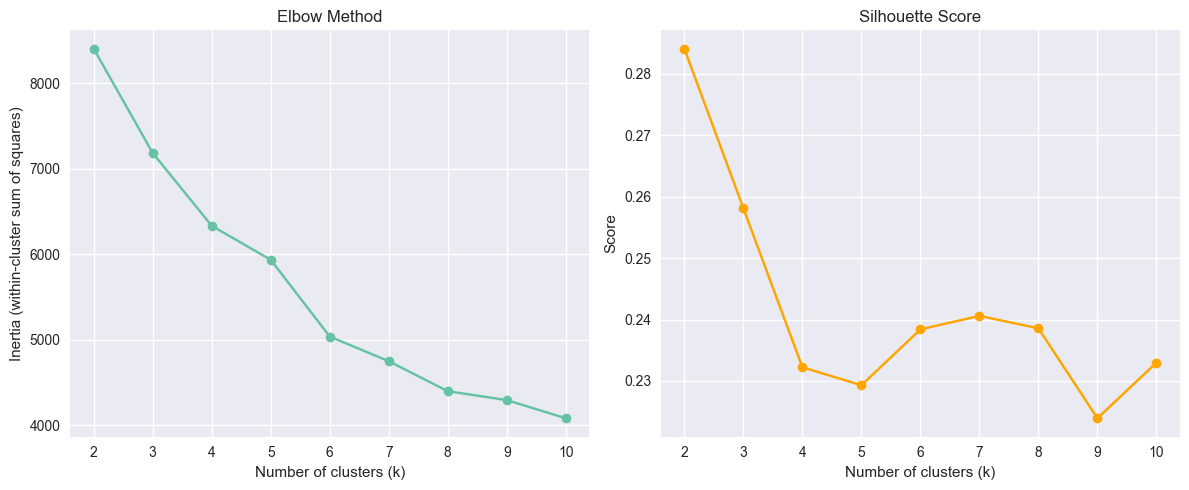

In [4]:
# ============================================
# 3) Optimize cluster count: Elbow & Silhouette
# ============================================

X = df_scaled[["Age", "Duration", "Credit amount", "Sex", "Job", "Housing",
               "Saving accounts", "Checking account", "Purpose"]].values

inertia = []        # # total error for each k
silhouette_scores = []  # silhouette score for each k

K = range(2, 11)  # test cluster numbers from 2 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    
    inertia.append(kmeans.inertia_)  # total error
    silhouette_scores.append(silhouette_score(X, labels))  # quality

# --- Let's plot the graphs ---
plt.figure(figsize=(12,5))

# Elbow
plt.subplot(1,2,1)
plt.plot(K, inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")

# Silhouette
plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, marker="o", color="orange")
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


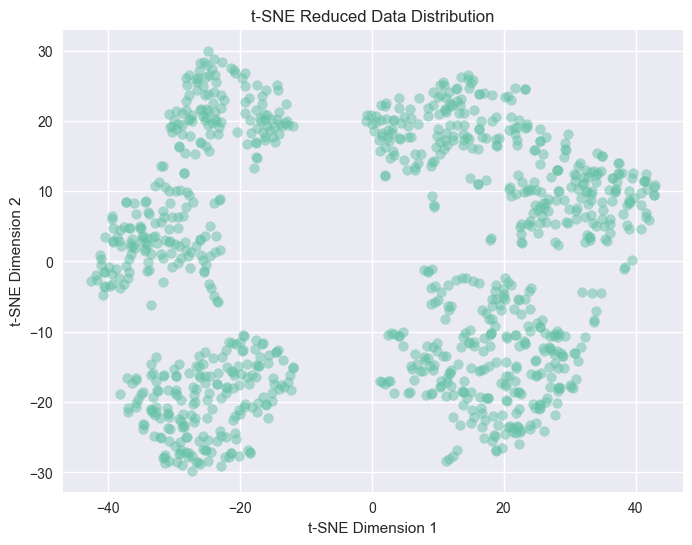

In [5]:
# ============================================
# 4) Dimensionality Reduction with t-SNE
# ============================================

# Get all scaled data (df_scaled)
X_scaled = df_scaled.values 

# Apply t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_scaled)

# Visualize the result
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)
plt.title("t-SNE Reduced Data Distribution")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.savefig("../images/alt_methods/tsne.png", dpi=150)
plt.show()

## Dimensionality Reduction with t-SNE

Since our dataset had 9 dimensions, it was impossible to visualize directly. To get a clearer picture of the data’s structure, I used **t-SNE** to reduce it to 2 dimensions. This allowed me to observe the overall distribution of the data in a more interpretable way.  

When I looked at the scatter plot, I noticed that the clusters were not cleanly separated. The points did not form clear spherical groups but instead appeared more entangled and irregular. This observation suggested that the assumption behind K-Means — that clusters are roughly spherical — might not hold true for this dataset.  

This pushed me to try an alternative algorithm. If the data structure is indeed irregular and overlapping, K-Means may not always be the best choice. That’s why I decided to test **DBSCAN**, which identifies clusters based on density rather than shape, and is theoretically more capable of handling complex structures.  

In short: t-SNE helped me realize that the data does not follow simple cluster assumptions, and this insight led me to experiment with DBSCAN.


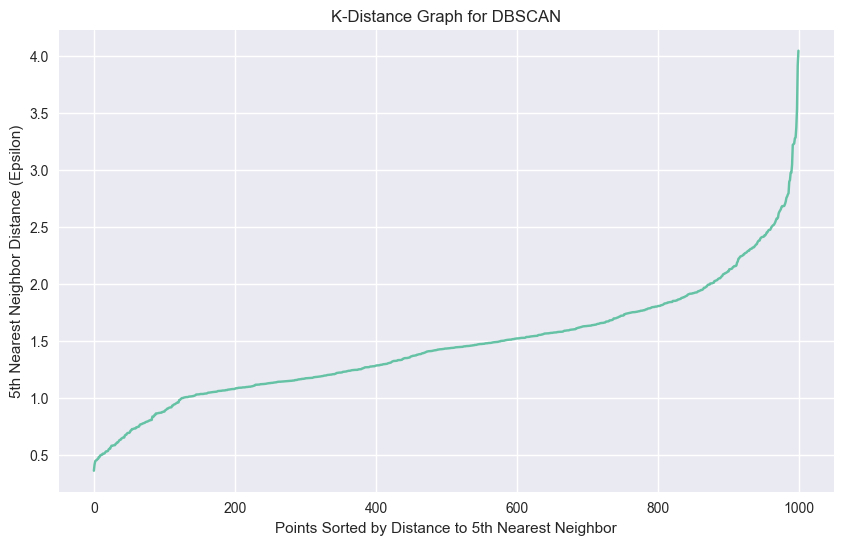

In [6]:
# ============================================
# 5) Find optimal 'eps' using k-distance graph
# ============================================

# For min_samples=5, we'll find the distance to the 5th nearest neighbor
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances
distances = np.sort(distances[:, 4], axis=0) # Index 4 is the 5th neighbor
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel("Points Sorted by Distance to 5th Nearest Neighbor")
plt.ylabel("5th Nearest Neighbor Distance (Epsilon)")
plt.title("K-Distance Graph for DBSCAN")
plt.savefig("../images/alt_methods/k_distance.png", dpi=150)
plt.show()

## Choosing Epsilon (ε) for DBSCAN

One of the key parts of DBSCAN is picking the right epsilon (ε).  
To do this, I plotted the k-distance graph, where each point’s distance to its 5th nearest neighbor is sorted.  

By looking at the curve, the “elbow point” stands out as the most reasonable choice for epsilon. I used this point as a guide to set a proper eps value.  


In [7]:
# ============================================
# 6) Alternative Clustering Model: DBSCAN
# ============================================

# A common way to choose eps is to plot k-distance graph
dbscan = DBSCAN(eps=0.8, min_samples=5) 
dbscan_labels = dbscan.fit_predict(X_scaled) # use the scaled data

# The number of clusters found (excluding noise)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Number of clusters found by DBSCAN: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise}")

# Add the DBSCAN labels to the dataframe for analysis
df_clusters_dbscan = df.copy()
df_clusters_dbscan["cluster"] = dbscan_labels

# quick view of cluster sizes
print("\nDBSCAN Cluster Sizes:")
print(df_clusters_dbscan["cluster"].value_counts().sort_index())

Number of clusters found by DBSCAN: 13
Number of noise points: 880

DBSCAN Cluster Sizes:
cluster
-1     880
 0      10
 1      24
 2      10
 3       7
 4       6
 5       9
 6       7
 7       7
 8       9
 9      11
 10      5
 11     10
 12      5
Name: count, dtype: int64


## Alternative Model: DBSCAN

After trying K-Means, I wanted to test a different algorithm, so I ran DBSCAN.  
The main difference is that DBSCAN doesn’t need you to set the number of clusters in advance it just finds dense areas and marks outliers as “noise.”  

Even though it looks like a nice method in theory, in practice it’s tricky on high-dimensional data. It’s very sensitive to parameters like epsilon (ε) and min_samples, so tuning them is critical to get meaningful results.  


In [8]:
# ============================================
# 7) Compare K-Means vs DBSCAN
# ============================================
print("\n--- Model Comparison ---")
print("K-Means Cluster Sizes:")
print(df_clusters["cluster"].value_counts().sort_index())

print("\nDBSCAN Cluster Sizes:")
print(df_clusters_dbscan["cluster"].value_counts().sort_index())

if n_clusters_dbscan > 1:
    dbscan_score = silhouette_score(X_scaled, dbscan_labels)
    print(f"\nSilhouette Score (K-Means, k=3): {silhouette_scores[1]:.4f}") # from the previous loop
    print(f"Silhouette Score (DBSCAN): {dbscan_score:.4f}")


--- Model Comparison ---
K-Means Cluster Sizes:
cluster
0    147
1    408
2    445
Name: count, dtype: int64

DBSCAN Cluster Sizes:
cluster
-1     880
 0      10
 1      24
 2      10
 3       7
 4       6
 5       9
 6       7
 7       7
 8       9
 9      11
 10      5
 11     10
 12      5
Name: count, dtype: int64

Silhouette Score (K-Means, k=3): 0.2581
Silhouette Score (DBSCAN): -0.3234


## K-Means vs DBSCAN Comparison

When I tried both side by side, here’s what I noticed:

- K-Means: Created balanced clusters, reasonable sizes, and even gave a positive silhouette score. That makes it practical for real use.  
- DBSCAN: Even after tuning parameters, it marked too many points as noise and clusters were too small. The silhouette score was negative, so it didn’t work out well.  

In the end: DBSCAN didn’t perform well on this dataset, while K-Means gave more stable and interpretable results. That’s why I decided to continue with K-Means as the final model.  
